In [4]:
#=======================================================================
# //2024-02-13: updated to work with ddg
# //2024-02-19: use Step 1.1 - Step 3 (straight run worked ok)
#
#=======================================================================

## Is it a bird?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: **downlevel** -- Download images of birds and non-birds
**see update below: section 1.1**

In [1]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 1.1: **Updated** Download images 
https://course20.fast.ai/images

#### //Test: using search_images_ddg

In [1]:
!pip install -Uq fastbook

In [2]:
from fastbook import *
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100,
 'http://4.bp.blogspot.com/-2_RuGHXGm0Y/UQW3vwH37JI/AAAAAAAAEzc/Mt1seFmFrog/s1600/Grizzly-Bear-.jpg')

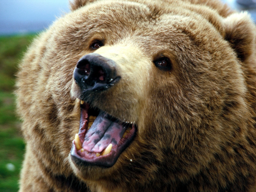

In [3]:
from fastdownload import download_url
dest = 'grizzly_bear.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

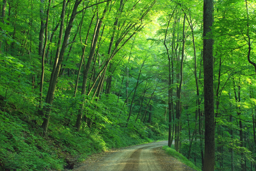

In [4]:
download_url(search_images_ddg('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [5]:
from time import sleep
from pathlib import Path
from tqdm import tqdm

In [6]:
download_images

<function fastai.vision.utils.download_images(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False)>

In [7]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [8]:
sleep

<function time.sleep>

In [10]:
searches = 'forest','bird'
path = Path('test_bird_or_not')
max = 300

for s in tqdm(searches):
    dest = (path/s)
    dest.mkdir(exist_ok=True, parents=True)
    
    download_images(dest, urls=search_images_ddg(f'{s} photo'), max_pics=max)
    sleep(10)  # Pause between searches to avoid over-loading server
    
    download_images(dest, urls=search_images_ddg(f'{s} sun photo'), max_pics=max)
    sleep(10)
    
    download_images(dest, urls=search_images_ddg(f'{s} shade photo'), max_pics=max)
    sleep(10)
    
    resize_images(path/s, max_size=400, dest=path/s)

100%|██████████| 2/2 [04:00<00:00, 120.17s/it]


## Step 2: Train our model

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

34

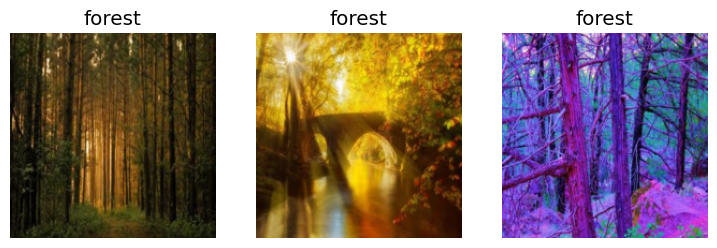

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=3)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.596523,0.149756,0.018779,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.121295,0.106173,0.023474,00:05
1,0.070678,0.093492,0.023474,00:05
2,0.046002,0.093486,0.023474,00:05


## Step 3: Use our model (and build your own!)

In [18]:
# is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
bird_jpg = 'test_bird_or_not/bird/03bd81a0-418a-4f51-a47e-c0d2daf3c4a0.jpg'
is_bird,_,probs = learn.predict(PILImage.create(bird_jpg))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
